# Importance Weights analysis

### Import Data

In [55]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [56]:
sim_path = '../../results/synth_classification_fixed_dataset_and_samples/09-05-2023-12:08'

In [57]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

runs_dirs = get_immediate_subdirectories(sim_path)

In [58]:
true_weights_list = {}
pre_AL_weights_list = {}
concept_list_dict = {}
metadata = {}

uncertainty_spreading_weights = {}
first_K_sampling_weights = {}
random_sampling_weights = {}

rs_selected_samples = {}
us_selected_samples = {}

STRATEGIES = [
    "RandomSampling",
    # "UncertaintySpreading"
]

for run in runs_dirs:
    with open(sim_path + '/'+ run +'/true_weights.json', 'r') as f:
        true_weights_list[run] = json.load(f)

    with open(sim_path + '/'+ run +'/pre_AL_weights.json', 'r') as f:
        pre_AL_weights_list[run] = json.load(f)

    with open(sim_path + '/'+ run +'/metadata.json', 'r') as f:
        metadata[run] = json.load(f)

    concept_list_dict[run] = []
    for n in range(metadata[run]['n_concepts']):

        # noinspection PyTypeChecker
        concept_list_dict[run].append(pd.read_csv(
            filepath_or_buffer=sim_path + '/'+ run + '/concept_' + str(n) + '.csv',
            dtype='str'
        ).astype('float64'))

    uncertainty_spreading_weights[run] = {}
    first_K_sampling_weights[run] = {}
    random_sampling_weights[run] = {}
    for strategy in STRATEGIES:

        strategy_path = sim_path + '/' + run + '/' + strategy

        if strategy == "RandomSampling":

           # noinspection PyTypeChecker
           rs_selected_samples[run] = pd.read_csv(
               filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
               dtype='str'
           ).astype('float64')

        elif strategy == "UncertaintySpreading":

            # noinspection PyTypeChecker
            us_selected_samples[run] = pd.read_csv(
                filepath_or_buffer=strategy_path + '/' + 'selected_samples.csv',
                dtype='str'
           ).astype('float64')

        for n in range(metadata[run]['n_samples']):

            n_sample = n + 1

            with open(strategy_path + '/' + str(n_sample) + '_samples.json', 'r') as f:

                if strategy == "RandomSampling":
                    random_sampling_weights[run][n_sample] = json.load(f)

                elif strategy == "UncertaintySpreading":
                    uncertainty_spreading_weights[run][n_sample] = json.load(f)

                elif strategy == "FirstKSampling":
                    first_K_sampling_weights[run][n_sample] = json.load(f)

In [59]:
rs_selected_samples


{'0':          X_0        X_1  y_0
 0   2.674535  -1.468781  0.0
 1   3.684635  -0.794417  0.0
 2   5.261738  11.568197  2.0
 3   1.521450   3.312261  0.0
 4   4.863477   1.797949  0.0
 5   3.586252  10.072948  2.0
 6   2.592259   0.172474  0.0
 7   3.156557  10.268054  2.0
 8   4.463066  -0.661432  0.0
 9   2.539266   7.978466  2.0
 10  2.830060  -1.357233  0.0
 11  3.002259  10.492891  2.0
 12  4.983550   8.171182  2.0
 13  1.595161  -0.148116  0.0
 14  3.933008  -1.051703  0.0
 15  4.758853  -0.643562  0.0
 16  3.934205   7.385627  2.0
 17  2.123297  -0.736103  0.0
 18  2.301476  -2.012913  0.0
 19  7.535422   2.263232  1.0
 20 -0.632519   5.730488  2.0
 21  7.340797   2.364850  1.0
 22  2.993891  -1.686981  0.0
 23  1.693590  -0.157402  0.0
 24  3.520348   2.144632  0.0
 25  3.819742   8.684740  2.0
 26  4.260036  -2.381062  0.0
 27  3.097358   9.251426  2.0
 28  3.181178  10.039478  2.0
 29  2.690422   6.925136  2.0
 30  3.909902   8.365734  2.0
 31  1.425247   3.563770  0.0
 32  

### Plot Concepts


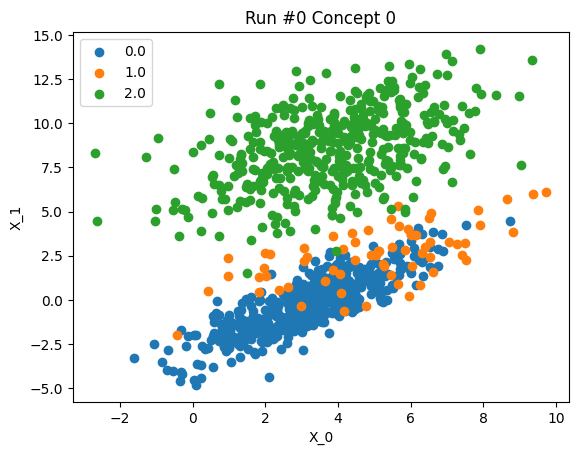

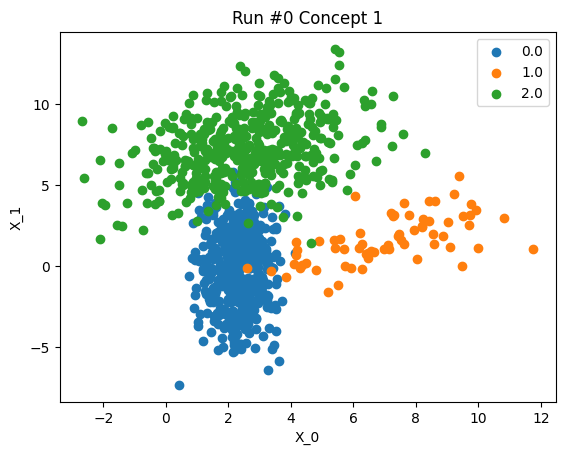

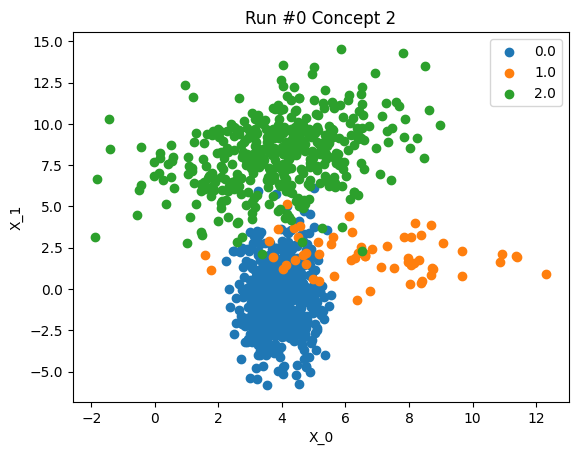

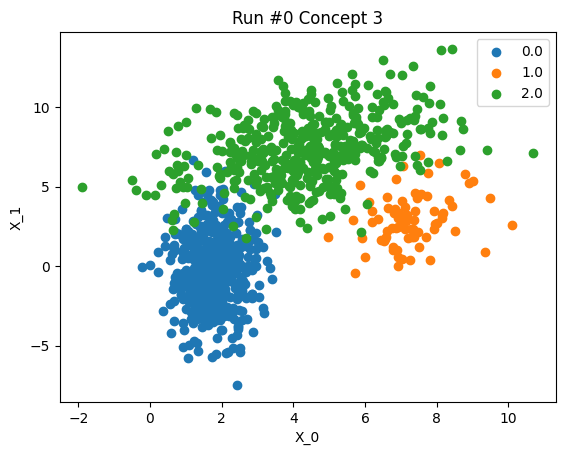

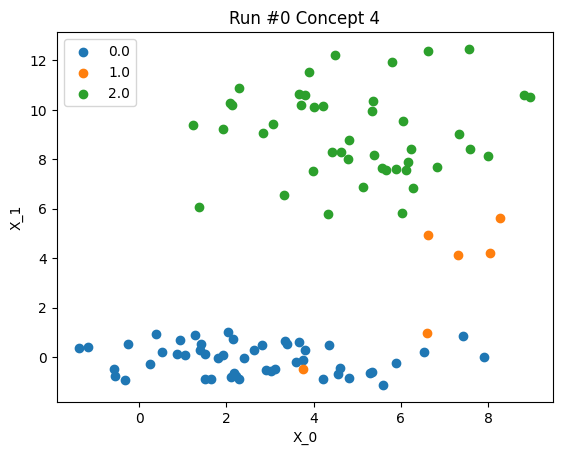

In [60]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label=label)
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()


### Compute MAE

In [61]:
mae_pre = [mean_absolute_error(true_weights_list[run], pre_AL_weights_list[run]) for run in runs_dirs]

mae_pre = np.average(mae_pre)
mae_pre

0.8147392193908164

In [62]:
mae_us = {}
for run in uncertainty_spreading_weights.keys():
    mae_us[run] = []
    for key in uncertainty_spreading_weights[run].keys():
        mae_us[run].append(mean_absolute_error(true_weights_list[run], uncertainty_spreading_weights[run][key]))


In [63]:
mae_rs = {}
for run in random_sampling_weights.keys():
    mae_rs[run] = []
    for key in random_sampling_weights[run].keys():
        mae_rs[run].append(mean_absolute_error(true_weights_list[run], random_sampling_weights[run][key]))

In [64]:
mae_us_mean = np.mean(a=list(mae_us.values()), axis=0)
mae_rs_mean = np.mean(a=list(mae_rs.values()), axis=0)

In [65]:
mae_us_mean

array([], dtype=float64)

### Plot Results

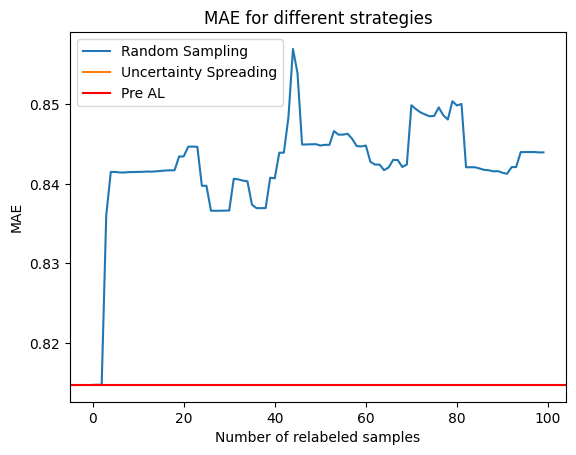

In [66]:
# create a new figure and axis object
fig, ax = plt.subplots()

# plot the MAE values for each model as a line
ax.plot(list(range(len(mae_rs_mean))), list(mae_rs_mean), label='Random Sampling')
ax.plot(list(range(len(mae_us_mean))),list(mae_us_mean), label='Uncertainty Spreading')
plt.axhline(y=mae_pre, color='r', linestyle='-', label='Pre AL')

# add a legend to the plot
ax.legend()

# set the x-axis label
ax.set_xlabel('Number of relabeled samples')

# set the y-axis label
ax.set_ylabel('MAE')

# set the title of the plot
ax.set_title('MAE for different strategies')

# display the plot
plt.show()


In [67]:
pd.set_option('display.max_rows', None)

In [68]:
unmatched_samples = rs_selected_samples

In [69]:
for (run, concept_list) in concept_list_dict.items():
    for concept in concept_list:
        unmatched_samples[run] = pd.merge(unmatched_samples[run], concept, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)


In [70]:
# useful to know how many samples have been relabeled with a different label
# from the original one when applying change to the select samples methods
len(unmatched_samples)

1

KeyError: '0'

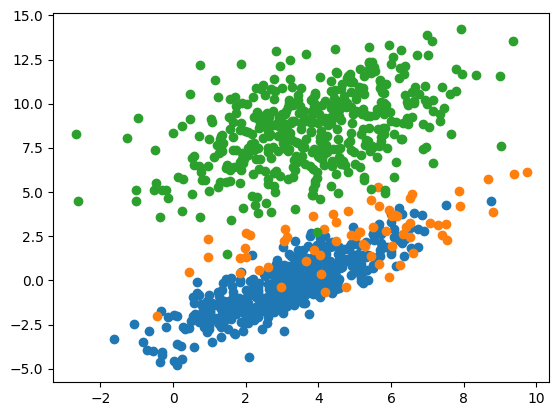

In [71]:
for (run, concept_list) in concept_list_dict.items():
    for index,concept in enumerate(concept_list):
        classes_groups = concept.groupby('y_0')

        fig, ax = plt.subplots()
        for i, (label, group) in enumerate(classes_groups):
            ax.scatter(group['X_0'], group['X_1'],
                    label='Class ' + str(int(label)))
        selected_samples_us = pd.merge(concept, us_selected_samples[run])
        selected_samples_rs = pd.merge(concept, rs_selected_samples[run])
        plt.scatter(selected_samples_us['X_0'], selected_samples_us['X_1'], c='red', marker='x', label='US count: ' + str(selected_samples_us.value_counts().count()))
        plt.scatter(selected_samples_rs['X_0'], selected_samples_rs['X_1'], c='black', marker='x', label='RS count: ' + str(selected_samples_rs.value_counts().count()))
        plt.xlabel('X_0')
        plt.ylabel('X_1')
        ax.legend()
        plt.title('Run #' + str(run) + ' Concept ' + str(index))
        plt.show()
